# Imagenet - LR 0.001 --> 0.0001 after 10 epochs

|S.No.|Optimization|Architecture|Pretrained|Pre-processing|Batch Count|Epochs|Loss Function|Optimizer|LR|Scheduler|Time per epoch|Test Acc|Val Acc|Overfitting| Underfitting|
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|1|Basic|Resnet50|No|Convert To Tensor|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.84|68.33|Yes|No|
|2|Resize Image|Resnet50|No|Resize Image|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.86|69.89|Yes|No|
|3|Normalized Image|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.89|70.34|Yes|No|
|4|LR 0.001|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.001|1.30|80.27|69.88|Yes|No|
|5|LR 0.001 --> 0.0001/10|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.001/0.0001|1.30|68.15|65.15|Yes|No|

## Summary
- Overall Val accuracy has been reduced to 65.15%
- Reduced LR from 0.001 to 0.0001 after 10th epoch 
- After 10th epoch test and val accuracy has constant difference and their values were not increasing significantly. Lines were almost parallel
- Diff between test and val acc after 30 epochs is 3 only.

## Install Packages

In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118 # Install packages in the correct order
!pip install numpy==1.24.3
!pip install tqdm matplotlib pillow
!pip install seaborn scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu118


## Check for CUDA and set device

In [2]:
# Verify CUDA availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.4.1+cu118
CUDA available: True
CUDA device: Tesla T4
Using device: cuda


## Import all packages

In [3]:
# Import all required libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import urllib.request
import zipfile
import shutil

## Verify installation and important package versions

In [4]:
# Verify installations
import numpy as np
print(f"Numpy version: {np.__version__}")

import torch
print(f"PyTorch version: {torch.__version__}")

import torchvision
print(f"Torchvision version: {torchvision.__version__}")

Numpy version: 1.24.3
PyTorch version: 2.4.1+cu118
Torchvision version: 0.19.1+cu118


In [5]:
## Application Constants
BATCH_SIZE = 128
NUM_CLASSES = 200
EPOCHS_COUNT = 30
LR = 0.001

## Download Dataset

In [6]:
# Download and extract Tiny ImageNet
def download_and_extract_tiny_imagenet():
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = "tiny-imagenet-200.zip"
    extract_path = "tiny-imagenet-200"
    
    if not os.path.exists(extract_path):
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(url, zip_path)
        
        print("Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("./")
        
        # Remove the zip file
        os.remove(zip_path)
        print("Dataset ready!")
    else:
        print("Dataset already exists!")
    
    return extract_path

In [7]:
# Prepare validation directory structure
def restructure_val_dir(dataset_path):
    val_dir = os.path.join(dataset_path, 'val')
    val_images_dir = os.path.join(val_dir, 'images')
    
    if os.path.exists(val_images_dir):
        # Read validation annotations file
        val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')
        with open(val_annotations_file, 'r') as f:
            val_annotations = f.readlines()
        
        # Create class directories and move images
        for line in val_annotations:
            parts = line.strip().split('\t')
            img_name, class_id = parts[0], parts[1]
            
            # Create class directory if it doesn't exist
            class_dir = os.path.join(val_dir, class_id)
            os.makedirs(class_dir, exist_ok=True)
            
            # Move image to class directory
            src_path = os.path.join(val_images_dir, img_name)
            dst_path = os.path.join(class_dir, img_name)
            if os.path.exists(src_path):
                shutil.move(src_path, dst_path)
        
        # Remove the original images directory and annotations file
        shutil.rmtree(val_images_dir)
        os.remove(val_annotations_file)

In [8]:
# Download and prepare dataset
dataset_path = download_and_extract_tiny_imagenet()
restructure_val_dir(dataset_path)

Dataset already exists!


## Define Transformations

In [9]:
# Define data transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Prepare Dataset

In [10]:
# Load datasets
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)


In [11]:
# Create data loaders
batch_size = BATCH_SIZE  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


## Load Resnet50 Model

In [12]:
# Load ResNet50 with pretrained=False for training from scratch
model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_classes = NUM_CLASSES
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


## Define Loss Function and Optimizer

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

## Train the model

In [14]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [15]:
# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [16]:
# Training loop
num_epochs = EPOCHS_COUNT
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Change LR 0.001 to 0.0001 after 10 epoch
    if epoch+1 > 10:
        optimizer = optim.SGD(model.parameters(), lr=0.0001)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")



Epoch 1/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.36it/s]


Train Loss: 5.2046 | Train Acc: 2.71%
Val Loss: 4.9923 | Val Acc: 8.86%

Epoch 2/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.57it/s]


Train Loss: 4.5759 | Train Acc: 19.64%
Val Loss: 4.1050 | Val Acc: 31.05%

Epoch 3/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.67it/s]


Train Loss: 3.5818 | Train Acc: 36.55%
Val Loss: 3.1023 | Val Acc: 42.98%

Epoch 4/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.73it/s]


Train Loss: 2.7477 | Train Acc: 46.80%
Val Loss: 2.4298 | Val Acc: 50.43%

Epoch 5/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.97it/s]


Train Loss: 2.2324 | Train Acc: 53.09%
Val Loss: 2.0694 | Val Acc: 54.67%

Epoch 6/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.84it/s]


Train Loss: 1.9388 | Train Acc: 56.93%
Val Loss: 1.8477 | Val Acc: 57.88%

Epoch 7/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.85it/s]


Train Loss: 1.7566 | Train Acc: 59.49%
Val Loss: 1.7057 | Val Acc: 60.21%

Epoch 8/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.77it/s]


Train Loss: 1.6279 | Train Acc: 61.64%
Val Loss: 1.6242 | Val Acc: 61.84%

Epoch 9/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]


Train Loss: 1.5317 | Train Acc: 63.38%
Val Loss: 1.5444 | Val Acc: 62.92%

Epoch 10/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.85it/s]


Train Loss: 1.4541 | Train Acc: 64.79%
Val Loss: 1.5026 | Val Acc: 63.71%

Epoch 11/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]


Train Loss: 1.4009 | Train Acc: 65.85%
Val Loss: 1.4908 | Val Acc: 64.11%

Epoch 12/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.52it/s]


Train Loss: 1.3950 | Train Acc: 65.97%
Val Loss: 1.4830 | Val Acc: 63.90%

Epoch 13/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.87it/s]


Train Loss: 1.3876 | Train Acc: 66.26%
Val Loss: 1.4764 | Val Acc: 64.07%

Epoch 14/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.84it/s]


Train Loss: 1.3834 | Train Acc: 66.19%
Val Loss: 1.4849 | Val Acc: 63.83%

Epoch 15/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.83it/s]


Train Loss: 1.3726 | Train Acc: 66.53%
Val Loss: 1.4786 | Val Acc: 63.63%

Epoch 16/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.66it/s]


Train Loss: 1.3692 | Train Acc: 66.43%
Val Loss: 1.4686 | Val Acc: 64.02%

Epoch 17/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.82it/s]


Train Loss: 1.3619 | Train Acc: 66.76%
Val Loss: 1.4602 | Val Acc: 64.40%

Epoch 18/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.88it/s]


Train Loss: 1.3598 | Train Acc: 66.66%
Val Loss: 1.4566 | Val Acc: 64.32%

Epoch 19/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.59it/s]


Train Loss: 1.3491 | Train Acc: 66.93%
Val Loss: 1.4622 | Val Acc: 64.18%

Epoch 20/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.57it/s]


Train Loss: 1.3444 | Train Acc: 67.10%
Val Loss: 1.4459 | Val Acc: 64.71%

Epoch 21/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.61it/s]


Train Loss: 1.3391 | Train Acc: 67.25%
Val Loss: 1.4450 | Val Acc: 64.47%

Epoch 22/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.52it/s]


Train Loss: 1.3347 | Train Acc: 67.31%
Val Loss: 1.4446 | Val Acc: 64.42%

Epoch 23/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.65it/s]


Train Loss: 1.3285 | Train Acc: 67.36%
Val Loss: 1.4418 | Val Acc: 64.50%

Epoch 24/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.73it/s]


Train Loss: 1.3220 | Train Acc: 67.45%
Val Loss: 1.4334 | Val Acc: 64.83%

Epoch 25/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.88it/s]


Train Loss: 1.3141 | Train Acc: 67.71%
Val Loss: 1.4321 | Val Acc: 64.94%

Epoch 26/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.61it/s]


Train Loss: 1.3105 | Train Acc: 67.72%
Val Loss: 1.4272 | Val Acc: 65.03%

Epoch 27/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.73it/s]


Train Loss: 1.3057 | Train Acc: 67.85%
Val Loss: 1.4354 | Val Acc: 64.78%

Epoch 28/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.69it/s]


Train Loss: 1.3012 | Train Acc: 67.93%
Val Loss: 1.4310 | Val Acc: 64.84%

Epoch 29/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.79it/s]


Train Loss: 1.2962 | Train Acc: 68.06%
Val Loss: 1.4202 | Val Acc: 64.95%

Epoch 30/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.94it/s]

Train Loss: 1.2882 | Train Acc: 68.15%
Val Loss: 1.4197 | Val Acc: 65.15%


## Plot Metrics

In [17]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

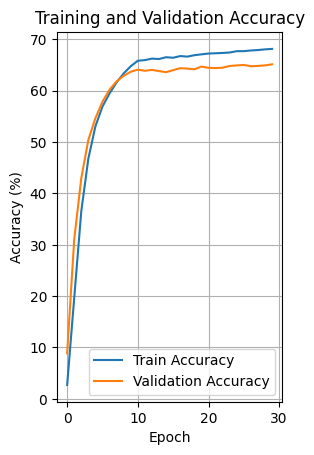

In [18]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

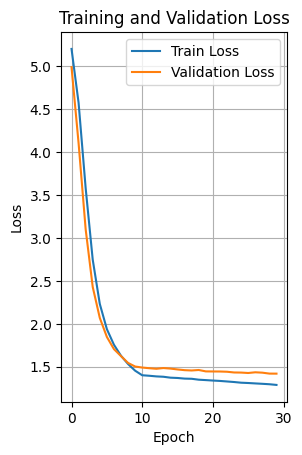

In [19]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

In [20]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## Save Model

In [21]:
# Save the model
torch.save(model.state_dict(), 'resnet50_tiny_imagenet.pth')

## Plot Misclassified Images

In [22]:
def get_class_name_mapping(dataset_path):
    """
    Create mapping from wnid to human-readable class names using words.txt
    """
    words_file = os.path.join(dataset_path, 'words.txt')
    wnid_to_name = {}
    
    try:
        with open(words_file, 'r') as f:
            for line in f:
                wnid, names = line.strip().split('\t')
                # Take the first comma-separated name if multiple exist
                name = names.split(',')[0].strip()
                wnid_to_name[wnid] = name
    except FileNotFoundError:
        print(f"Warning: words.txt not found at {words_file}")
        # Create a simple mapping if words.txt is not available
        wnid_to_name = {class_id: class_id for class_id in train_dataset.classes}
    
    return wnid_to_name

In [23]:
def denormalize(tensor):
    """
    Denormalize the image tensor for visualization
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

In [24]:
def get_misclassified_images(model, val_loader, class_mapping, num_images=20):
    """
    Get misclassified images with their true and predicted labels
    """
    model.eval()
    misclassified_images = []
    true_classes = []
    pred_classes = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Find misclassified images
            mask = (predicted != labels)
            misclassified_idx = mask.nonzero(as_tuple=True)[0]
            
            for idx in misclassified_idx:
                if len(misclassified_images) >= num_images:
                    break
                
                # Get wnids
                true_wnid = train_dataset.classes[labels[idx].item()]
                pred_wnid = train_dataset.classes[predicted[idx].item()]
                
                # Get human-readable names
                true_class_name = class_mapping.get(true_wnid, true_wnid)
                pred_class_name = class_mapping.get(pred_wnid, pred_wnid)
                
                misclassified_images.append(images[idx].cpu())
                true_classes.append(true_class_name)
                pred_classes.append(pred_class_name)
                
            if len(misclassified_images) >= num_images:
                break
    
    return misclassified_images, true_classes, pred_classes

In [25]:
def plot_misclassified(images, true_classes, pred_classes, num_images=20):
    """
    Plot misclassified images in a grid
    """
    if len(images) < num_images:
        num_images = len(images)
    
    num_rows = (num_images + 4) // 5  # 5 images per row
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4*num_rows))
    axes = axes.ravel()
    
    for idx in range(num_images):
        # img = denormalize(images[idx])
        img = images[idx]
        img = torch.clamp(img, 0, 1)
        
        # Format class names
        true_class = true_classes[idx]
        pred_class = pred_classes[idx]
        
        # Truncate long class names
        true_display = true_class[:25] + '...' if len(true_class) > 25 else true_class
        pred_display = pred_class[:25] + '...' if len(pred_class) > 25 else pred_class
        
        axes[idx].imshow(img.permute(1, 2, 0))
        axes[idx].axis('off')
        title = f'True: {true_display}\nPred: {pred_display}'
        axes[idx].set_title(title, fontsize=10, color='red', pad=10)
    
    # Turn off any unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [26]:
# Get class name mapping
class_mapping = get_class_name_mapping(dataset_path)

In [27]:
# Get misclassified images
misclassified_images, true_classes, pred_classes = get_misclassified_images(
    model, val_loader, class_mapping
)

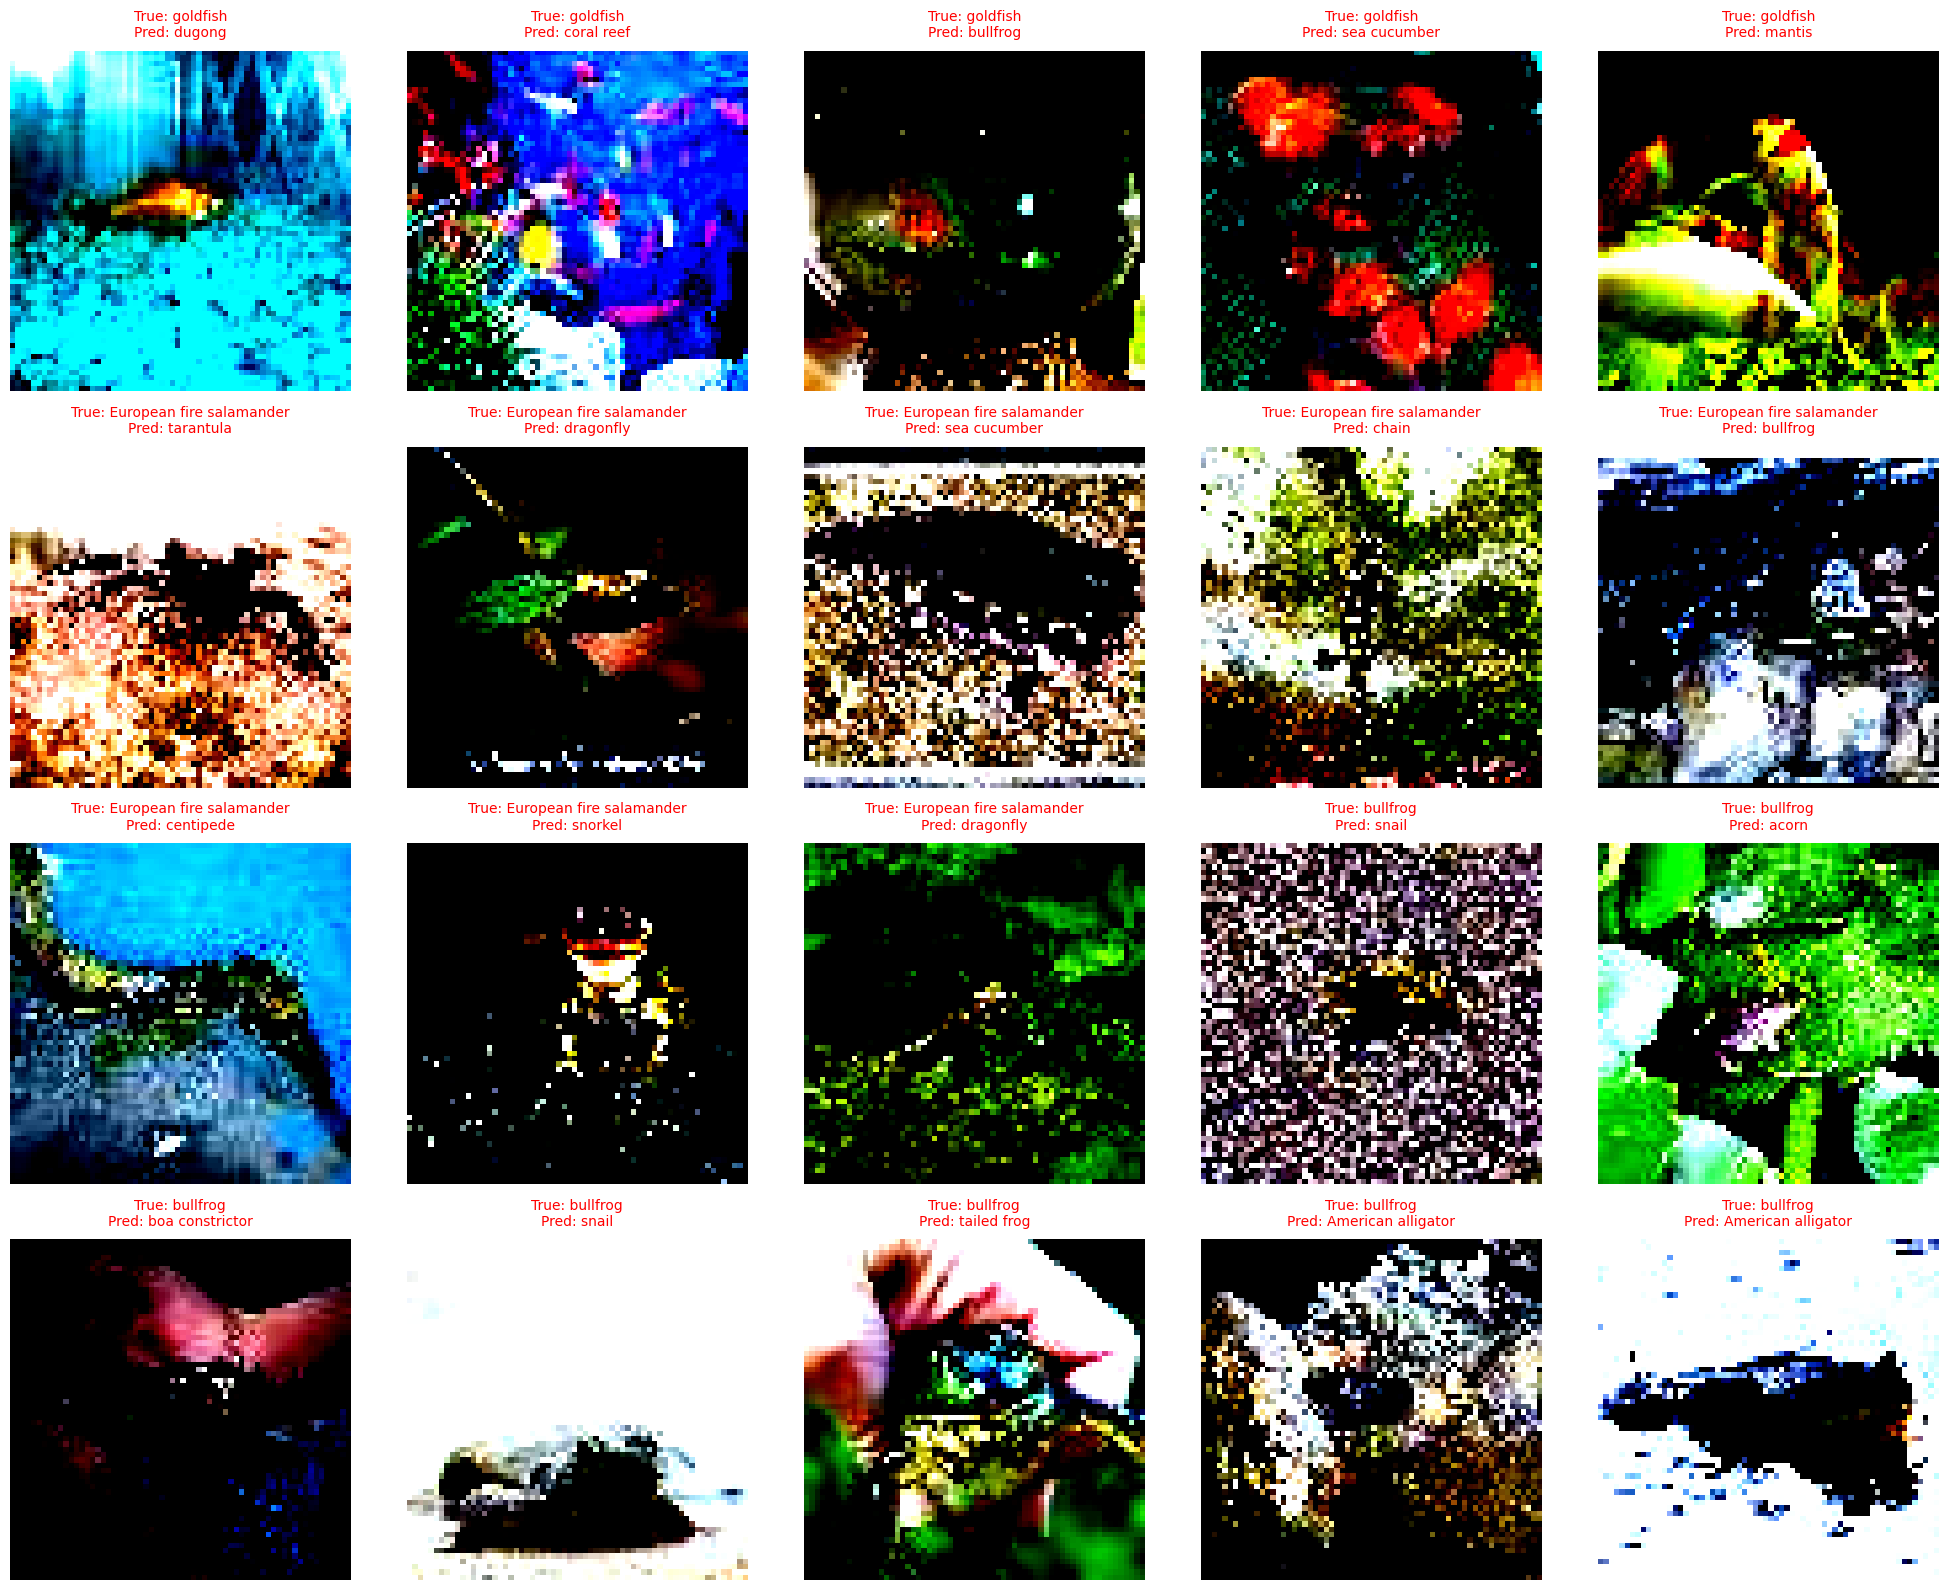

In [28]:
# Plot misclassified images
plot_misclassified(misclassified_images, true_classes, pred_classes)

In [29]:
# Print model accuracy
print("\nEvaluating model on validation set...")
model.eval()
correct = 0
total = 0
class_correct = {}
class_total = {}

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Per-class accuracy
        for label, pred in zip(labels, predicted):
            label_name = class_mapping[train_dataset.classes[label.item()]]
            if label_name not in class_total:
                class_total[label_name] = 0
                class_correct[label_name] = 0
            class_total[label_name] += 1
            if label == pred:
                class_correct[label_name] += 1
                
# Overall accuracy
accuracy = 100 * correct / total
print(f"\nOverall Model Accuracy: {accuracy:.2f}%")

# Print per-class accuracy
print("\nPer-class Accuracy:")
accuracies = []
for class_name in class_total:
    class_acc = 100 * class_correct[class_name] / class_total[class_name]
    accuracies.append((class_name, class_acc))

# Sort by accuracy
accuracies.sort(key=lambda x: x[1], reverse=True)

# Print top 10 and bottom 10 classes
print("\nTop 10 Best Performing Classes:")
for class_name, acc in accuracies[:10]:
    print(f"{class_name[:40]:<40}: {acc:.2f}%")

print("\nBottom 10 Worst Performing Classes:")
for class_name, acc in accuracies[-10:]:
    print(f"{class_name[:40]:<40}: {acc:.2f}%")

# Analyze misclassifications
print("\nMost Common Misclassifications:")
misclass_count = {}
for true_class, pred_class in zip(true_classes, pred_classes):
    if true_class not in misclass_count:
        misclass_count[true_class] = {}
    if pred_class not in misclass_count[true_class]:
        misclass_count[true_class][pred_class] = 0
    misclass_count[true_class][pred_class] += 1

for true_class in misclass_count:
    print(f"\nTrue class: {true_class}")
    sorted_misclass = sorted(misclass_count[true_class].items(), 
                            key=lambda x: x[1], 
                            reverse=True)
    for pred_class, count in sorted_misclass[:3]:
        print(f"  Predicted as {pred_class}: {count} times")


Evaluating model on validation set...


100%|██████████| 79/79 [00:03<00:00, 22.05it/s]


Overall Model Accuracy: 65.15%

Per-class Accuracy:

Top 10 Best Performing Classes:
gazelle                                 : 96.00%
dugong                                  : 94.00%
school bus                              : 92.00%
goldfish                                : 90.00%
sulphur butterfly                       : 90.00%
Yorkshire terrier                       : 88.00%
bullet train                            : 88.00%
triumphal arch                          : 88.00%
espresso                                : 88.00%
alp                                     : 88.00%

Bottom 10 Worst Performing Classes:
ox                                      : 42.00%
military uniform                        : 42.00%
bucket                                  : 40.00%
kimono                                  : 38.00%
reel                                    : 38.00%
pole                                    : 34.00%
wooden spoon                            : 34.00%
umbrella                                : 32

# ChatGPT

When you observe that **both training and validation accuracy increase at a very slow rate** after reducing the learning rate, and the **gap between train and validation accuracy remains constant**, this typically suggests that your model has reached a **point of saturation** or **plateau** in its learning process. This means the model is no longer making significant improvements because:

### **Possible Causes:**
1. **Learning Saturation:**
   - After reducing the learning rate, the model’s updates are much smaller, which can make training progress slower. If the learning rate is too small, the model may be stuck in a local minimum or not exploring the parameter space efficiently enough to improve further.
   
2. **Insufficient Capacity of the Model or Data:**
   - The model might have learned all it can from the data given its current architecture, or there may not be enough **discriminative information** in the dataset for the model to improve significantly further.
   
3. **Overfitting Stabilization:**
   - The model might have stabilized after overcoming early overfitting, but now the improvements are minimal. If the training and validation accuracies are close together, this could also suggest that the model is no longer overfitting and has reached a **generalization equilibrium**.
   
4. **Data Limitations:**
   - The dataset (especially if it's small or simple) might not contain enough complexity to continue driving improvements in the model's performance. A small dataset can often limit how much a model can improve beyond a certain point.

### **What Could Be Done to Improve Accuracy Beyond Epoch 10?**

#### **1. Experiment with Learning Rate Schedulers:**
   - If the learning rate is too small, the model may not be making significant progress. Instead of using a fixed learning rate, try using a **learning rate scheduler** that **gradually increases** the learning rate after it has plateaued for a few epochs, or you can apply **cyclical learning rates** (CLR) to allow the model to jump out of local minima and explore the parameter space more effectively.
   
   - **Learning rate warm-up**: Gradually increasing the learning rate after a few epochs can help the model recover from slow progress.
   - **How to implement it**: For example, in Keras/TensorFlow, you can use the **ReduceLROnPlateau** callback to adjust the learning rate based on validation performance:
     ```python
     from tensorflow.keras.callbacks import ReduceLROnPlateau
     lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
     model.fit(..., callbacks=[lr_scheduler])
     ```

#### **2. Try Different Optimizers:**
   - **Adam**, **RMSprop**, or other **adaptive optimizers** might help the model improve more efficiently as they adjust the learning rate for individual parameters. If you’re still using SGD, switching to an adaptive optimizer like Adam might lead to smoother and faster convergence, especially after the learning rate is reduced.

#### **3. Use Advanced Regularization Techniques:**
   - **Weight Regularization** (L2 or L1) or **Dropout** may help prevent the model from becoming too "comfortable" at a plateau and can encourage it to continue improving by forcing it to focus on the most important features.
   
   - **Data Augmentation** (if not already applied) can provide more variety to the training set and help the model improve. This can reduce the risk of the model overfitting to the current data.
   
   - **Cutout**: A more aggressive form of augmentation, where random square regions of the image are cut out, can force the model to learn more robust features.
   
   - **Example for Dropout**:
     ```python
     from tensorflow.keras.layers import Dropout
     model.add(Dropout(0.5))  # Adding dropout in layers
     ```

#### **4. Explore Transfer Learning and Fine-Tuning:**
   - **Fine-tuning pre-trained models**: If you are using a pre-trained model like ResNet50, you can **fine-tune** the last few layers of the network (i.e., the classifier layers). This allows the model to learn specific features for your task.
     - **How to do it**: Unfreeze the top layers of your pre-trained model and retrain them at a lower learning rate, while keeping the early layers frozen.
     ```python
     # Example in Keras
     for layer in model.layers[:140]:  # Freeze the first 140 layers
         layer.trainable = False
     for layer in model.layers[140:]:  # Unfreeze the rest
         layer.trainable = True
     model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
     ```

#### **5. Increase Model Complexity or Modify Architecture:**
   - If the model has reached a plateau, it could indicate that the architecture is not sufficiently powerful for the task at hand. Consider:
     - **Adding more layers or units**: Increase the model’s complexity by adding more layers or increasing the number of neurons in the existing layers.
     - **Change the architecture**: Explore different model architectures or modifications of ResNet (e.g., **ResNet-34**, **DenseNet**), or consider combining models using **ensembling** methods to improve performance.

#### **6. Cross-Validation & Hyperparameter Search:**
   - If you haven’t already, perform a **hyperparameter search** (e.g., random search or grid search) over learning rates, dropout rates, and other parameters. This can often help find better configurations that might lead to higher performance.
   
   - **Cross-validation** (if not done already) can help ensure your model isn't just tuned for a specific validation set but instead has robust generalization.

#### **7. Use More Data (if possible):**
   - **Data Augmentation**: If your dataset is small, generating new data via augmentation techniques (e.g., rotations, flips, etc.) can increase the model’s exposure to different features and improve its ability to generalize.
   
   - **Acquire more data**: If feasible, try to gather more labeled data for training. More diverse data generally leads to better model performance.

### **Summary:**
- **Slow learning after epoch 10** could suggest your model has hit a plateau, and its ability to improve is limited by factors like a too-small learning rate or overfitting stabilization.
- To improve:
  1. Experiment with **learning rate schedulers** or **cyclical learning rates**.
  2. Switch to more **advanced optimizers** like Adam or RMSprop.
  3. Apply stronger **regularization** techniques like **dropout** or **L2 regularization**.
  4. **Fine-tune** pre-trained models or **increase model complexity**.
  5. Explore **transfer learning**, **cross-validation**, and **hyperparameter tuning**.

By trying these strategies, you can help push past the stagnation point and achieve better model performance.